# Этап 1. Загрузка данных
датасет - CelebA, из атрибутов выбираем только *открытый/закрытый* рот и улыбка/нет улыбки.

In [ ]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/S-aiueo32/lpips-pytorch.git to /tmp/pip-req-build-r3fakucr
  Running command git clone --filter=blob:none --quiet https://github.com/S-aiueo32/lpips-pytorch.git /tmp/pip-req-build-r3fakucr
  Resolved https://github.com/S-aiueo32/lpips-pytorch.git to commit 016e0ae19ceff83450590738948941a7eb9b95b7
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for lpips-pytorch: filename=lpips_pytorch-latest-py3-none-any.whl size=4978 sha256=b15044c460ace08f5cc45c1777d16ae31dda402da7966c26715c46fdc550d7a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-3czd55k9/wheels/87/4a/82/33dbec8a13aa8126fdb0b083756d0cbfadd9773c52e8a660fb
Failed to build lpips-pytorch
  Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a w

In [ ]:
!pip install munch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import re
import numpy as np
import torch

CUR_DIR = os.path.dirname(os.path.abspath("/content/DeepGenerativeModels"))


## Create a custom Dataset class
class CelebADataset(Dataset):
    def __init__(self, root_dir=os.path.join('/content/DeepGenerativeModels/data/celeba'), transform=None):
        """
        Args:
          root_dir (string): Directory with all the images
          transform (callable, optional): transform to be applied to each image sample
        """
        # Read names of images in the root directory
        
        # Path to folder with the dataset
        if not os.path.isdir(root_dir):
            os.makedirs(root_dir)
        dataset_folder = f'/content/DeepGenerativeModels/img_align_celeba/'
        self.dataset_folder = os.path.abspath(dataset_folder)


        image_names = os.listdir(self.dataset_folder)
        print(f"Всего картинок: {len(image_names)}")
        self.transform = transform 
        image_names = natsorted(image_names)
        
        self.filenames = []
        self.annotations = []
        with open(f'/content/drive/My Drive/gen_models/list_attr_celeba_new.txt') as f:
            for i, line in enumerate(f.readlines()):
                line = re.sub(' *\n', '', line)
                if i == 0:
                    self.all_h = re.split(' +', line)
                    # self.header = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Eyeglasses', 'Chubby', 'Double_Chin', 'Male', 'Smiling', 'Wearing_Hat', 'Mouth_Slightly_Open'] 
                    self.header = ['Smiling', 'Mouth_Slightly_Open']   
                else:
                    values = re.split(' +', line)
                    filename = values[0]
                    self.filenames.append(filename)
                    res_attr = []
                    # tags = ['Black_Hair', 'Blond_Hair','Eyeglasses', 'Chubby', 'Double_Chin', 'Gray_Hair', 'Male', 'Smiling', 'Wearing_Hat', 'Mouth_Slightly_Open']
                    for t in self.header:
                      res_attr.append((int(values[self.all_h.index(t)+1])+1)/2)
                    self.annotations.append(res_attr)
                    
        self.annotations = np.array(self.annotations)    
              
    def __len__(self): 
        return len(self.filenames)

    def __getitem__(self, idx):
        # Get the path to the image 
        img_name = self.filenames[idx]
        img_path = os.path.join(self.dataset_folder, img_name)
        img_attributes = self.annotations[idx] # convert all attributes to zeros and ones
        # Load image and convert it to RGB
        img = Image.open(img_path).convert('RGB')
        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)
        return img, {'filename': img_name, 'idx': idx, 'attributes': torch.tensor(img_attributes).long()}
    


Подключаю диск:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab.patches import cv2_imshow


path = "/content/drive/My Drive/gen_models/"

Mounted at /content/drive


Разархивирую датасет (вытащила в отдельную строку, чтоб удобнее было отслеживать ошибки)

In [ ]:
zip_file = "/content/drive/My Drive/gen_models/img_align_celeba.zip"
z = zipfile.ZipFile(zip_file, "r")
z.extractall()

In [ ]:
import sys; sys.path.append('../../utils/')

# import datasets
import torch
import torch.nn.functional as F
from lpips_pytorch import LPIPS
from torchvision import transforms
from munch import Munch
import gc
from tqdm.auto import trange


## Setup
# Number of gpus available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = Munch()



# Spatial size of training images, images are resized to this size.
args.img_size = 64*4

# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])
# Load the dataset from file and apply transformations
dataset = CelebADataset(transform=transform)

args.num_domains = len(dataset.header)
print(f"Число доменов: {args.num_domains}")
args.batch_size = 32
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False


# dataloader for batched data loading
dataloader = torch.utils.data.DataLoader(dataset,
                                                batch_size=args.batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: latest is an invalid version and will not be supported in a future release
  warnings.warn(


Всего картинок: 202599
Число доменов: 2


## Визуализация датасетов

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

{'Smiling': 1, 'Mouth_Slightly_Open': 1}
{'filename': '043766.jpg', 'idx': 43765, 'attributes': tensor([1, 1])}
{'Smiling': 0, 'Mouth_Slightly_Open': 0}
{'filename': '097990.jpg', 'idx': 97989, 'attributes': tensor([0, 0])}
{'Smiling': 1, 'Mouth_Slightly_Open': 1}
{'filename': '074256.jpg', 'idx': 74255, 'attributes': tensor([1, 1])}
{'Smiling': 1, 'Mouth_Slightly_Open': 1}
{'filename': '180711.jpg', 'idx': 180710, 'attributes': tensor([1, 1])}
{'Smiling': 1, 'Mouth_Slightly_Open': 1}
{'filename': '158643.jpg', 'idx': 158642, 'attributes': tensor([1, 1])}
{'Smiling': 1, 'Mouth_Slightly_Open': 1}
{'filename': '050381.jpg', 'idx': 50380, 'attributes': tensor([1, 1])}
{'Smiling': 0, 'Mouth_Slightly_Open': 1}
{'filename': '030481.jpg', 'idx': 30480, 'attributes': tensor([0, 1])}
{'Smiling': 1, 'Mouth_Slightly_Open': 1}
{'filename': '020929.jpg', 'idx': 20928, 'attributes': tensor([1, 1])}
{'Smiling': 0, 'Mouth_Slightly_Open': 0}
{'filename': '188307.jpg', 'idx': 188306, 'attributes': tenso

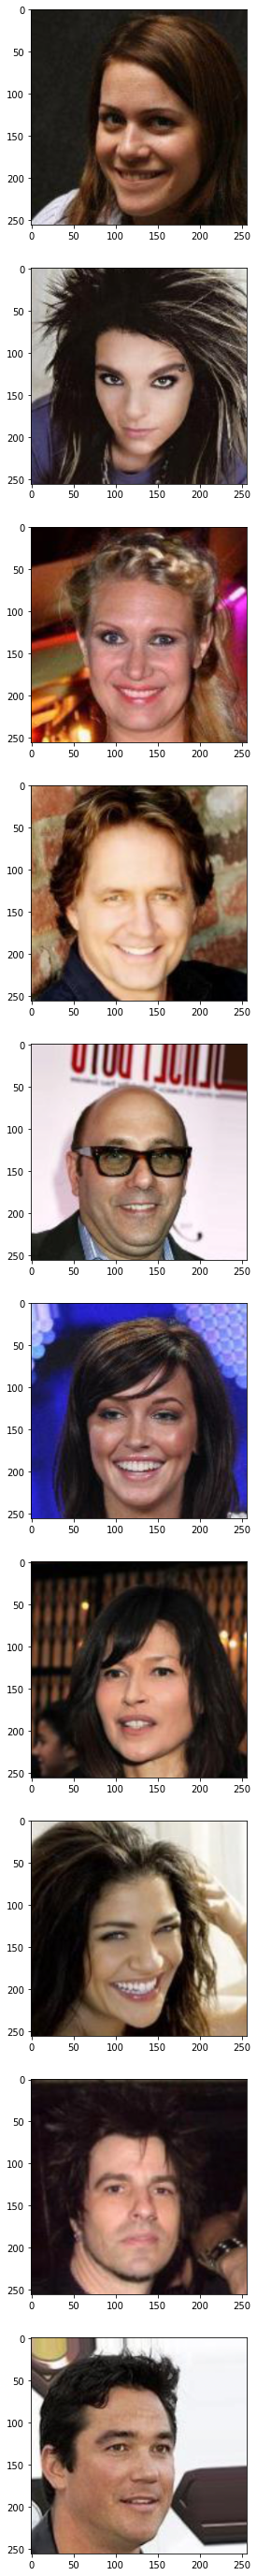

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images_cnt = 10
plt.figure(figsize=(17,images_cnt*5))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    # attributes dict for a given image. Contains 40 attributes
    attributes = {k:v for k,v in zip(dataset.header, target['attributes'].detach().cpu().numpy())}
    plt.subplot(images_cnt,1,i+1)
    plt.imshow(inv_normalize(img).detach().cpu().numpy().transpose(1,2,0))
    print(attributes)
    print(target)

Для сравнения, картинки без денормализации:

{'Smiling': 0, 'Mouth_Slightly_Open': 0}
{'filename': '061601.jpg', 'idx': 61600, 'attributes': tensor([0, 0])}
{'Smiling': 0, 'Mouth_Slightly_Open': 0}
{'filename': '001622.jpg', 'idx': 1621, 'attributes': tensor([0, 0])}
{'Smiling': 0, 'Mouth_Slightly_Open': 0}
{'filename': '003800.jpg', 'idx': 3799, 'attributes': tensor([0, 0])}
{'Smiling': 0, 'Mouth_Slightly_Open': 0}
{'filename': '076277.jpg', 'idx': 76276, 'attributes': tensor([0, 0])}
{'Smiling': 1, 'Mouth_Slightly_Open': 1}
{'filename': '111146.jpg', 'idx': 111145, 'attributes': tensor([1, 1])}
{'Smiling': 0, 'Mouth_Slightly_Open': 0}
{'filename': '019472.jpg', 'idx': 19471, 'attributes': tensor([0, 0])}
{'Smiling': 1, 'Mouth_Slightly_Open': 0}
{'filename': '176331.jpg', 'idx': 176330, 'attributes': tensor([1, 0])}
{'Smiling': 0, 'Mouth_Slightly_Open': 1}
{'filename': '026292.jpg', 'idx': 26291, 'attributes': tensor([0, 1])}
{'Smiling': 1, 'Mouth_Slightly_Open': 1}
{'filename': '129057.jpg', 'idx': 129056, 'attributes': tensor(

{'Smiling': 0, 'Mouth_Slightly_Open': 0}
{'filename': '158395.jpg', 'idx': 158394, 'attributes': tensor([0, 0])}


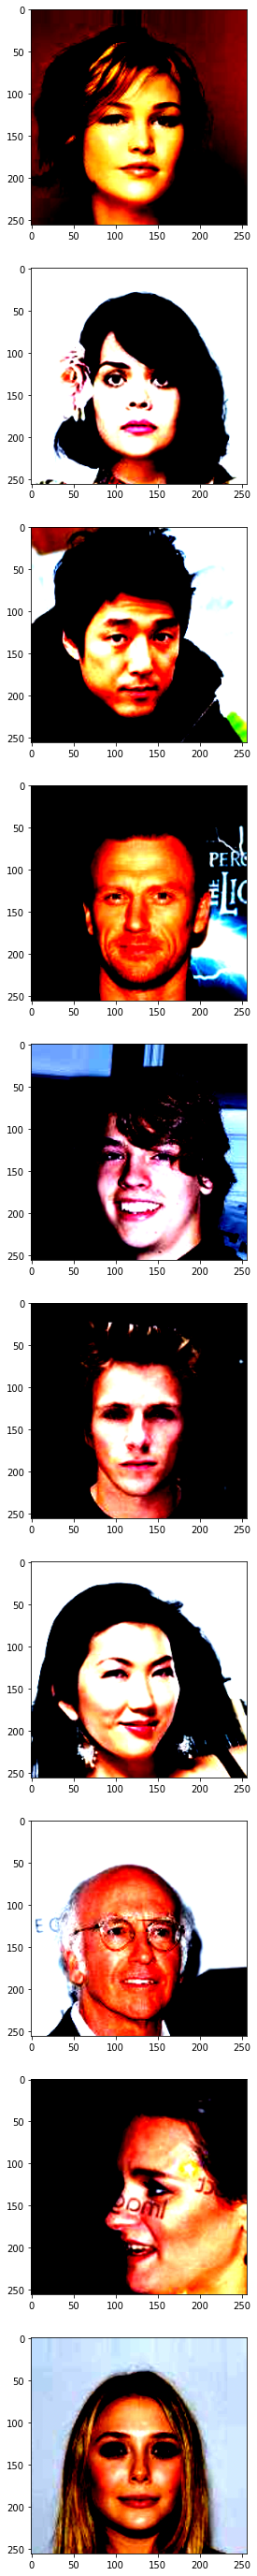

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images_cnt = 10
plt.figure(figsize=(17,images_cnt*5))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    # attributes dict for a given image. Contains 40 attributes
    attributes = {k:v for k,v in zip(dataset.header, target['attributes'].detach().cpu().numpy())}
    plt.subplot(images_cnt,1,i+1)
    plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))
    print(attributes)
    print(target)

# Этап 2. Обучение модели
Реализую [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) 

In [ ]:
import torch
import torch.nn as nn


class Generator(nn.Module):

    def __init__(self, c_dim):
        super(Generator, self).__init__()
        self.g = nn.Sequential(
            #-------Down-sampling--------------------
            nn.Conv2d(3+c_dim, 64, kernel_size=7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            #--------Bottleneck---------------------------
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
# (так 6 раз)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),


            #-------Up-sampling-----------------------------
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3, bias=False),
            nn.Tanh()
        )
        

    def forward(self, x, c):
            # labels = self.label_embedding(labels).view(-1, 1, self.config.noise_shape, self.config.noise_shape)
            c = c.view(c.size(0), c.size(1), 1, 1)
            c = c.repeat(1, 1, x.size(2), x.size(3))
            x = torch.cat([x, c], dim=1)
            # print(f"size = {x.size()}")
            return self.g(x)


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.d = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.01),

                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.01),

                nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.01),

                nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.01),

                nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.01),

                nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.01)
        )
        self.conv1 = nn.Conv2d(2048, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(2048, 2, kernel_size=4, bias=False)
        
    def forward(self, x):
            h = self.d(x)
            out_src = self.conv1(h)
            out_cls = self.conv2(h)
            # print(out_cls.size())
            return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))



In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates, _ = D(interpolates)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(device), # gradients w.t. output. 1 is default
        create_graph=True,
        retain_graph=True, # keep all gradients for further optimization steps
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty    

In [ ]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
device = torch.device('cuda')

# generator = Generator(2).to(device)
# discriminator = Discriminator().to(device)

generator = torch.load("/content/drive/My Drive/gen_models/2010gen")
discriminator = torch.load("/content/drive/My Drive/gen_models/2010disc")


generator = generator.to(device)
discriminator = discriminator.to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer =  torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))


losses = {
    'D': [],
    'G': []
}


In [ ]:
c_dim = 2
num_iters = 10
lambda_cls = 1
lambda_gp = 1
n_critic = 5
lambda_rec = 10


for i in range(num_iters):
    for index, (image, labels) in tqdm(enumerate(dataloader)):
        # print("start batch")

        labels = labels["attributes"] 

        new_labels = labels[torch.randperm(len(labels))] # лайфхак: перемешиваем старые лейблы - получаем новые (чтобы не заморачиваться с генерёжкой цветов волос)

        image = image.to(device)          
        labels = labels.to(device)     
        new_labels = new_labels.to(device)   

# дискриминатор

        out_src, out_cls = discriminator(image)
        # print(out_cls.size())
        d_loss_real = - torch.mean(out_src)


        # real_loss = F.binary_cross_entropy_with_logits(out_real, torch.ones_like(out_real) * 0.9)
        # fake_loss = F.binary_cross_entropy_with_logits(out_fake, torch.zeros_like(out_fake))

        d_loss_cls = F.binary_cross_entropy_with_logits(out_cls.float(), labels.float(), size_average=False) / len(out_cls)
        # print("num classes: " + str(out_cls.size(0)))
        

        fake_img = generator(image, new_labels)
        out_src, out_cls = discriminator(fake_img.detach())
        d_loss_fake = torch.mean(out_src)

        d_loss = d_loss_real + d_loss_fake + lambda_cls * d_loss_cls + lambda_gp * compute_gradient_penalty(discriminator, image, fake_img)

        g_optimizer.zero_grad()
        d_optimizer.zero_grad()

        d_loss.backward()

        losses['D'].append(d_loss.item())

        d_optimizer.step()

# генератор

        if (index+1) % n_critic == 0:
            fake_img = generator(image, new_labels)
            out_src, out_cls = discriminator(fake_img)
            g_loss_fake = - torch.mean(out_src)
            g_loss_cls =  F.binary_cross_entropy_with_logits(out_cls.float(), new_labels.float(), size_average=False) / out_cls.size(0)
  
            x_reconst = generator(fake_img, labels)
            g_loss_rec = torch.mean(torch.abs(image - x_reconst))

            g_loss = g_loss_fake + lambda_rec * g_loss_rec + lambda_cls * g_loss_cls
         
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            g_loss.backward()

            losses['G'].append(g_loss.item())

            g_optimizer.step()



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

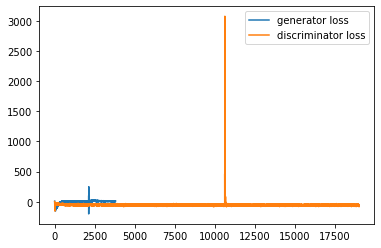

In [ ]:
plt.plot(losses['G'], label='generator loss')
plt.plot(losses['D'], label='discriminator loss')
plt.legend()
plt.show()

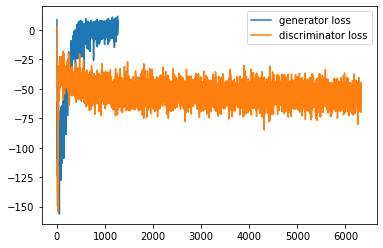

In [ ]:
plt.plot(losses['G'], label='generator loss')
plt.plot(losses['D'], label='discriminator loss')
plt.legend()
plt.show()

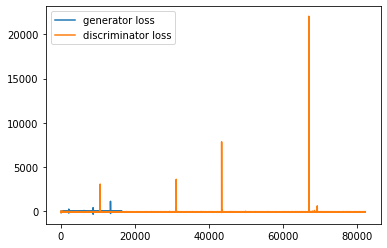

In [ ]:
plt.plot(losses['G'], label='generator loss')
plt.plot(losses['D'], label='discriminator loss')
plt.legend()
plt.show()

In [ ]:
torch.save(generator, '/content/drive/My Drive/gen_models/200gen7')
torch.save(discriminator, '/content/drive/My Drive/gen_models/200disc7')

# Evaluation

In [ ]:
! pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lpips

lpips = lpips.LPIPS() 

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [ ]:
generator = torch.load("/content/drive/My Drive/gen_models/2010gen")

Посмотрим на сами картинки: (синие, тк в cv2 цветовое пространство BGR, потом поменяю),главное - рот закрыт, никто не улыбается.

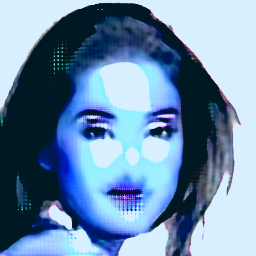

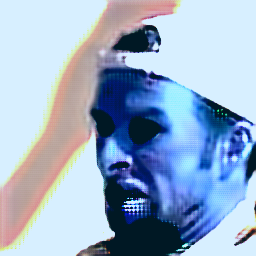

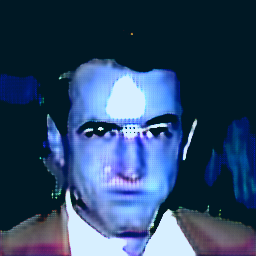

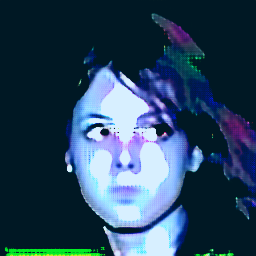

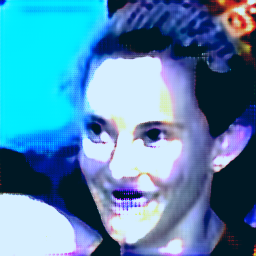

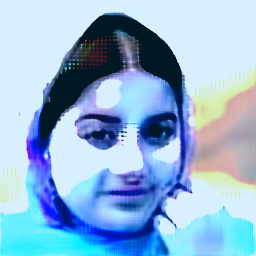

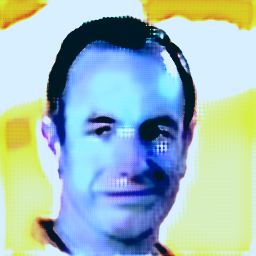

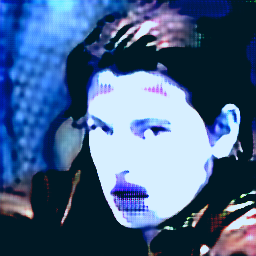

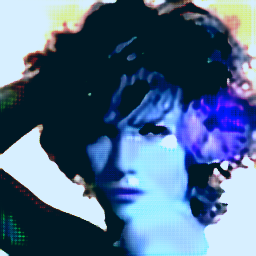

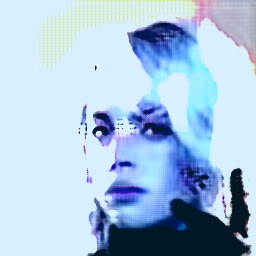

<Figure size 1440x1440 with 0 Axes>

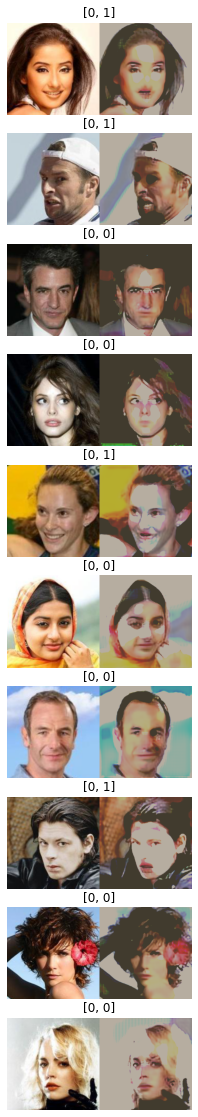

In [ ]:
# открытый рот
with torch.no_grad():

    plt.figure(figsize=(20, 20))
    x_real, label = next(iter(dataloader))
    labels = label['attributes']
    x_real = x_real.to(device)
    labels = labels.to(device)  
   
    labels[:,0] = 0 
   
    x_f2 = generator(x_real, labels)
num_images = 10
plt.figure(figsize=(num_images*20,20))    
for i in range(num_images):
    plt.subplot(num_images, 1, i+1)
    plt.imshow(np.hstack([inv_normalize(x_real[i]).permute(1,2,0).detach().cpu().numpy(), inv_normalize(x_f2[i]).permute(1,2,0).detach().cpu().numpy()]))
    # print(np.max(denorm(x_fake[i].permute(1,2,0).detach().cpu()).numpy()))
    res = inv_normalize(x_f2[i]).permute(1,2,0).detach().cpu().numpy()
    res = cv2.normalize(res, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    cv2_imshow(res)
    plt.axis('off')
    plt.title(str(labels[i].tolist()))


torch.Size([1, 3, 256, 256])


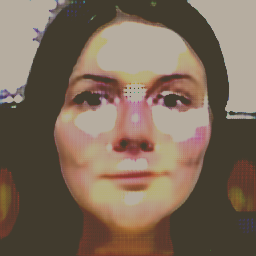

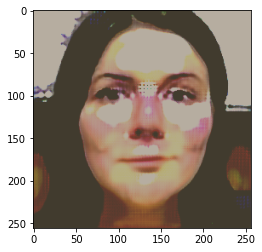

In [ ]:
image = Image.open("/content/drive/My Drive/gen_models/test.jpg").convert('RGB')
plt.imshow(image)
transform=transforms.Compose([
    transforms.Resize(64*4),
    transforms.CenterCrop(64*4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])
img = transform(image)
img = img.unsqueeze(0)
print(img.size())
labels = torch.Tensor([[0, 0]])
x_f2 = generator(img.to(device), labels.to(device))
res = inv_normalize(x_f2[0]).permute(1,2,0).detach().cpu().numpy()
plt.imshow(res)
cv2_imshow(255*res[:,:,::-1])